In this notebook, we will learn about the various ways in which [ImgLib2](https://imglib2.net) is lazy.

First let's add the necessary dependencies.  We will use [ImageJ](https://imagej.nih.gov/ij/) to load example images and to generate [`RenderedImage`](https://docs.oracle.com/en/java/javase/17/docs/api/java.desktop/java/awt/image/RenderedImage.html) outputs that we can use to render in the notebook.  Then, we will import [ImgLib2](https://imglib2.net) and the modules to share data between ImgLib2 and ImageJ and the [`imglib2-realtransform` module](https://github.com/imglib/imglib2-realtransform) that includes various transformations.

In [1]:
%mavenRepo scijava.public https://maven.scijava.org/content/groups/public
%maven net.imglib2:imglib2-ij:2.0.2
//%maven jitk:jitk-tps:3.0.4
//%maven net.imglib2:imglib2-realtransform:4.0.3

//%mavenRepo scijava.public https://maven.scijava.org/content/groups/public
//%maven org.janelia.saalfeldlab:n5-ij:4.2.5
//%maven jitk:jitk-tps:3.0.4
//%maven net.imglib2:imglib2-realtransform:4.0.3

import ij.*;
import io.github.spencerpark.jupyter.kernel.display.common.*;
import io.github.spencerpark.jupyter.kernel.display.mime.*;
import net.imglib2.*;
import net.imglib2.img.imageplus.*;
import net.imglib2.img.display.imagej.*;
import net.imglib2.view.*;

Let's open one of ImageJ's example images and show it in the notebook.  This uses [Spencer Park's image renderer](https://github.com/SpencerPark/jupyter-jvm-basekernel/blob/master/src/main/java/io/github/spencerpark/jupyter/kernel/display/common/Image.java):

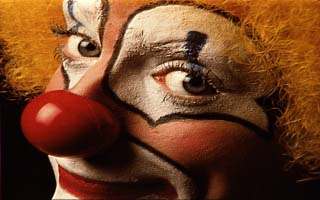

In [2]:
var imp = IJ.openImage("https://mirror.imagej.net/ij/images/clown.jpg");
imp.getBufferedImage();

If we want to work with this image in ImgLib2, we need to provide it as an ImgLib2 interface:

In [3]:
var imp = IJ.openImage("https://mirror.imagej.net/ij/images/clown.jpg");
// for later use without the compiler losing its mind, we must provide type information
// for the ImagePlus wrapper, so let's not use var here
RandomAccessibleInterval<?> rai = ImagePlusImgs.from(imp);
rai;

IntImagePlus [320x200]

There is no default renderer for ImgLib2 interfaces available to the notebook kernel, so we see a default `String` representation of the result (when rendering this cell the first time).  So let's register some simple renderers that use [ImgLib2's ImageJ bridge](https://github.com/imglib/imglib2-ij/blob/master/src/main/java/net/imglib2/img/display/imagej/ImageJFunctions.java) and [Spencer Park's image renderer](https://github.com/SpencerPark/jupyter-jvm-basekernel/blob/master/src/main/java/io/github/spencerpark/jupyter/kernel/display/common/Image.java) to render ImgLib2 data into the notebook.  We add a version that renders the first 2D slice of a `RandomAccessibleInterval` and a second version that renders a default interval `512x512+0+0` of the 2D slice at position 0 in all other dimensions of an infinite `RandomAccessible`.

In [4]:
getKernelInstance().getRenderer().createRegistration(RandomAccessibleInterval.class)
        .preferring(MIMEType.IMAGE_PNG)
        .supporting(MIMEType.IMAGE_JPEG, MIMEType.IMAGE_GIF)
        .register((rai, context) -> Image.renderImage(
                ImageJFunctions.wrap(rai, rai.toString()).getBufferedImage(),
                context));

getKernelInstance().getRenderer().createRegistration(RandomAccessible.class)
        .preferring(MIMEType.IMAGE_PNG)
        .supporting(MIMEType.IMAGE_JPEG, MIMEType.IMAGE_GIF)
        .register((ra, context) -> Image.renderImage(
                ImageJFunctions.wrap(
                        Views.interval(
                                ra,
                                new FinalInterval(
                                        Arrays.copyOf(
                                                new long[]{1024, 1024},
                                                ra.numDimensions()))),
                        ra.toString()).getBufferedImage(),
                context));

Now let's try the same again:

In [5]:
var imp = IJ.openImage("https://mirror.imagej.net/ij/images/clown.jpg");
// for later use without the compiler losing its mind, we must provide type information
// for the ImagePlus wrapper, so let's not use var here
RandomAccessibleInterval<?> rai = ImagePlusImgs.from(imp);
display(rai, "image/gif");
//display(rai, "image/jpeg");
//display(rai, "image/png");


EvalException: org/scijava/Named

Ok, great!  Let's try the 'infinite' version:

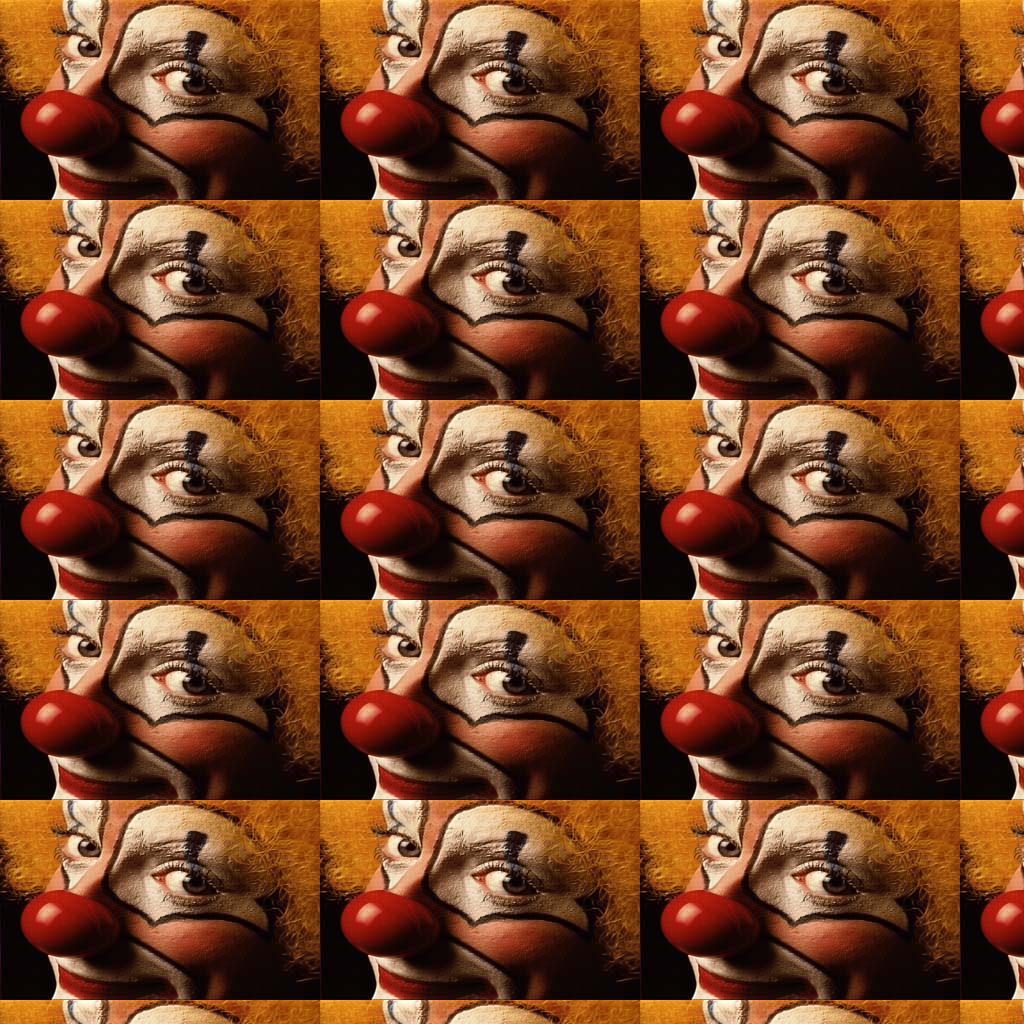

In [8]:
var ra = Views.extendPeriodic(rai);
ra;

Wonderful!  We can of course still render a `String` representation or alternative encodings with the [injected `display` methods of the kernel]( https://github.com/SpencerPark/IJava/blob/master/docs/display.md):

IntImagePlus [320x200]

net.imglib2.view.ExtendedRandomAccessibleInterval@77358af1

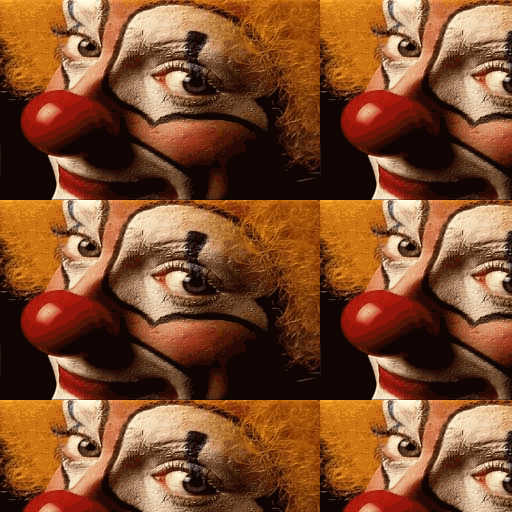

d2a6a0c5-6317-4a88-9486-9867eb63315b

In [9]:
display(rai, "text/plain");
display(ra, "text/plain");
display(rai, "image/jpeg");
display(ra, "image/gif");

You may have noticed that the output of this cell ends with an obscure identifier.  We see this, because we did not catch the output of the `display` method which provides an identifier for the output object that it generates.  This identifier can be used to update the contents of this object.  We can use this to render simple animations, e.g. to slice through a 3D volume.  Let's try this with a 3D volume from the ImageJ example images:

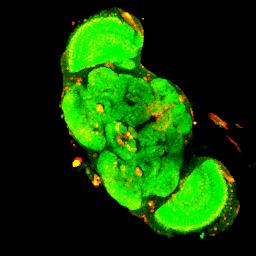

slice 56

In [10]:
var imp = IJ.openImage("https://mirror.imagej.net/ij/images/flybrain.zip");
RandomAccessibleInterval<?> rai = ImagePlusImgs.from(imp);
var refSlice = display(Views.hyperSlice(rai, 2, rai.dimension(2) / 2), "image/jpeg");
var refLabel = display("slice " + rai.dimension(2) / 2);
for (int z = 0; z < rai.dimension(2); ++z) {
    var slice = Views.hyperSlice(rai, 2, z);
    updateDisplay(refSlice, slice, "image/jpeg");
    updateDisplay(refLabel, "slice " + z);
    Thread.sleep(100);
}
// for static notebook export
updateDisplay(refSlice, Views.hyperSlice(rai, 2, rai.dimension(2) / 2), "image/jpeg");

Of course, you can only see the animation if you actually run the notebook cell.  In a future iteration, we are planning to implement an animated GIF generator for offline animations, but not this time.  Let's see what else we can do with these renderers.

First, let's apply some transformations to images.  Already in the above border extension example as well as in the slicing animation, we have used ImgLib2's default behavior to apply transformations lazily, i.e. only when a 'pixel' is actually queried (e.g. to render it into a `RenderedImage` raster), the transformations are applied.  Transformations can be applied to both coordinates and values.  Lets apply some transformations to values:

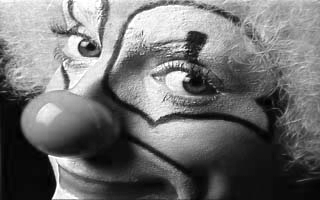

red

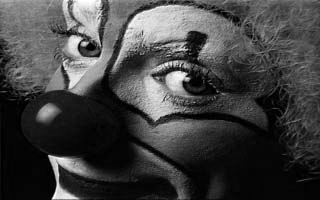

green

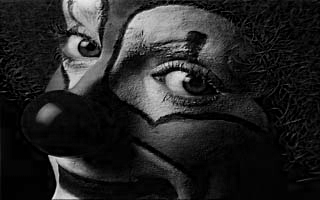

blue

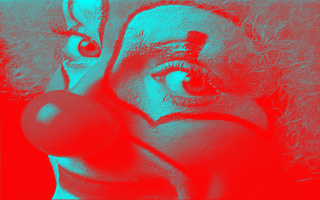

grey to red-cyan ramp

feff6934-90fe-4634-a676-7da9cc2f4a96

In [11]:
import net.imglib2.converter.*;
import net.imglib2.type.numeric.*;

var imp = IJ.openImage("https://mirror.imagej.net/ij/images/clown.jpg");
RandomAccessibleInterval<ARGBType> rai = ImagePlusImgs.from(imp);
display(Converters.argbChannel(rai, 1));
display("red");
display(Converters.argbChannel(rai, 2));
display("green");
display(Converters.argbChannel(rai, 3));
display("blue");

display(
        Converters.<ARGBType, ARGBType>convert2(
                rai,
                (in, out) -> {
    
                    final int argb = in.get();
                    final double grey = 0.3 * ARGBType.red(argb) + 0.6 * ARGBType.green(argb) + 0.1 * ARGBType.blue(argb);
                    out.set(ARGBType.rgba(255 - grey, grey, grey, 255));
                },
                ARGBType::new));
display("grey to red-cyan ramp");

And now some integer coordinate transformations:

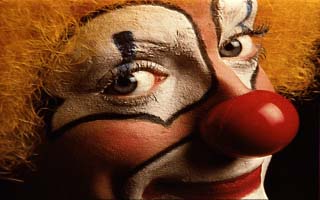

flip axis 0

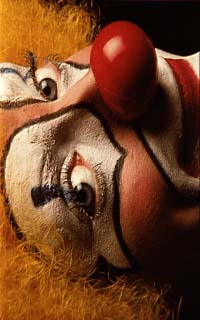

permute axes

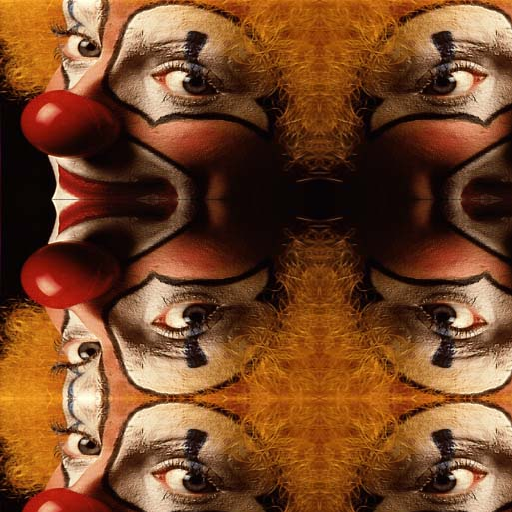

mirror extension without repeated border pixels

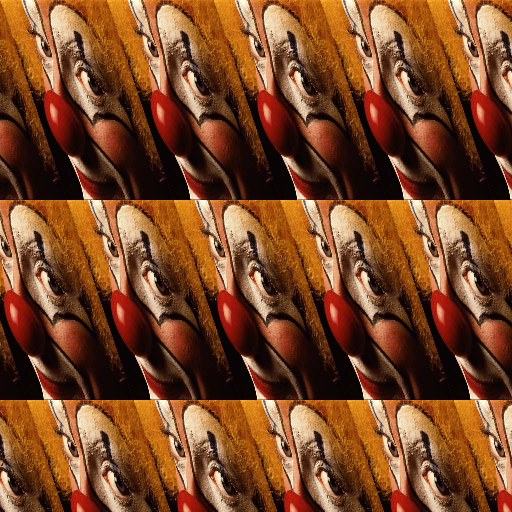

extend periodically, shear axis 1 into axis 0, subsample by (3, 1)

bc3bee37-f7f3-4377-9846-e0fdf6cb8542

In [12]:
display(Views.invertAxis(rai, 0));
display("flip axis 0");

display(Views.permute(rai, 0, 1));
display("permute axes");

display(Views.extendMirrorSingle(rai));
display("mirror extension without repeated border pixels");

display(Views.subsample(Views.shear(Views.extendPeriodic(rai), 0, 1), 3, 1));
display("extend periodically, shear axis 1 into axis 0, subsample by (3, 1)");

While most trivial integer transformations such as flipping axes work on intervals, you probably noticed that we had to extend the image to infinity in order to shear it, so ImgLib2 can provide values for coordinates outside of the source interval.  For real coordinate transformations we will also need to interpolate values at non-integer coordinates.  Finally, in order to render the result, we have to read it from a raster.  Let's do this:

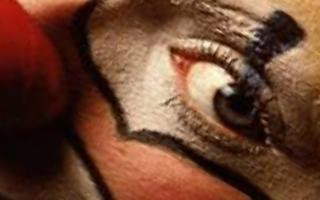

1.72,-0.99,-16.22
0.99,1.72,-231.50


In [13]:
import net.imglib2.interpolation.randomaccess.*;
import net.imglib2.realtransform.*;

var imp = IJ.openImage("https://mirror.imagej.net/ij/images/clown.jpg");
RandomAccessibleInterval<ARGBType> rai = ImagePlusImgs.from(imp);
var ra = Views.extendValue(rai, new ARGBType(0xff00ff00)); // < green background
var interpolated = Views.interpolate(ra, new ClampingNLinearInterpolatorFactory<>()); // n-linear interpolation
/**
 * This would be
 * var interpolated = Views.interpolate(ra, new NLinearInterpolatorFactory<>());
 * if you have no concern about value overflows
 */
var affine = new AffineTransform2D();
var transformed = Views.interval(RealViews.affine(interpolated, affine), rai); // shortcut for affines
var refImage = display(transformed, "image/jpeg");
var refLabel = display("", "text/html");

final int steps = 20;
for (int i = 0; i < steps; ++i) {
    affine.translate(-rai.dimension(0) / 2, -rai.dimension(1) / 2);
    affine.rotate(Math.PI / 6.0 / steps);
    affine.scale(1.0 + 0.7 / steps);
    affine.translate(rai.dimension(0) / 2, rai.dimension(1) / 2);
    
    updateDisplay(refImage, Views.interval(transformed, rai), "image/jpeg");
    updateDisplay(
            refLabel,
            String.format("""
                            <p>affine transformation matrix:</p>
                            <table>
                            <tr><td>%.2f</td><td>%.2f</td><td>%.2f</td></tr>
                            <tr><td>%.2f</td><td>%.2f</td><td>%.2f</td></tr>
                            </table>""",
                    affine.get(0, 0), affine.get(0, 1), affine.get(0, 2),
                    affine.get(1, 0), affine.get(1, 1), affine.get(1, 2)), "text/html");
    Thread.sleep(100);
}

Affine transformation are probably the most well known and simple real coordinate transformations, but there are many more.  Let's try a `ThinplateSplineTransform` and format text output with markdown:

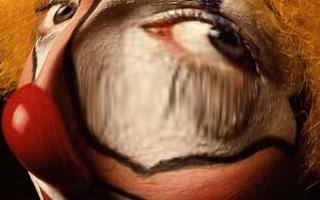

thinplate spline transformation controls points:

| | p<sub>x</sub> | p<sub>y</sub> | q<sub>x</sub> | q<sub>y</sub> |
| --- | ---: | ---: | ---: | ---: |
| 0 | 0.00 | 0.00 | 0.00 | 0.00 |
| 1 | 320.00 | 0.00 | 320.00 | 0.00 |
| 2 | 0.00 | 200.00 | 0.00 | 200.00 |
| 3 | 320.00 | 200.00 | 320.00 | 200.00 |
| 4 | 80.00 | 50.00 | 118.00 | 88.00 |
| 5 | 240.00 | 50.00 | 202.00 | 88.00 |
| 6 | 80.00 | 150.00 | 118.00 | 112.00 |
| 7 | 240.00 | 150.00 | 202.00 | 112.00 |


SLF4J: Failed to load class "org.slf4j.impl.StaticLoggerBinder".
SLF4J: Defaulting to no-operation (NOP) logger implementation
SLF4J: See http://www.slf4j.org/codes.html#StaticLoggerBinder for further details.


In [14]:
var refImage = display(rai, "image/jpeg");
var refLabel = display("", "text/markdown");

int steps = 20;
double stretch = 40;
for (int i = 0; i < steps; ++i) {
    final double offset = stretch * i / steps;
    final double[][] p = {
            {0, rai.dimension(0), 0, rai.dimension(0), rai.dimension(0) * 0.25, rai.dimension(0) * 0.75, rai.dimension(0) * 0.25, rai.dimension(0) * 0.75},
            {0, 0, rai.dimension(1), rai.dimension(1), rai.dimension(1) * 0.25, rai.dimension(1) * 0.25, rai.dimension(1) * 0.75, rai.dimension(1) * 0.75}
    };
    final double[][] q = {
            {0, rai.dimension(0), 0, rai.dimension(0),
            rai.dimension(0) * 0.25 + offset , rai.dimension(0) * 0.75 - offset, rai.dimension(0) * 0.25 + offset, rai.dimension(0) * 0.75 - offset},
            {0, 0, rai.dimension(1), rai.dimension(1),
            rai.dimension(1) * 0.25 + offset, rai.dimension(1) * 0.25 + offset, rai.dimension(1) * 0.75 - offset, rai.dimension(1) * 0.75 - offset}
    };
    final var transform = new ThinplateSplineTransform(p, q);
    final var warped = new RealTransformRandomAccessible<>(interpolated, transform);
    String text = """
thinplate spline transformation controls points:
            
| | p<sub>x</sub> | p<sub>y</sub> | q<sub>x</sub> | q<sub>y</sub> |
| --- | ---: | ---: | ---: | ---: |
""";
    for (int j = 0; j < p[0].length; ++j)
        text += String.format("""
| %d | %.2f | %.2f | %.2f | %.2f |
""",
                j, p[0][j], p[1][j], q[0][j], q[1][j]);                

    updateDisplay(refImage, Views.interval(warped, rai), "image/jpeg");
    updateDisplay(refLabel, text, "text/markdown");

    Thread.sleep(100);
}